In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
import tensorboard as tb
from tqdm.auto import tqdm

from tensorflow.python.summary.summary_iterator import summary_iterator

%load_ext autoreload
%autoreload 2

2025-08-18 13:50:25.997898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 13:50:27.550320: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 13:50:27.754674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-18 13:50:28.132199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-18 13:50:28.366720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 13:50:29.442120: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
from glob import glob
# event_files = glob('../../logs_ray_torch/ExtensiveHPO_seqconv/seqconv/**/events.out*', recursive=True)

def argsort(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)

hist_glob_path = ''
def get_val_loss_hists(path):
    event_files_all = glob(path, recursive=True)
    used_event_files = []
    val_loss_hists = []
    N_hists = 0
    for i,f in enumerate(event_files_all):
        val_losses = []
        for e in summary_iterator(f):
            for v in e.summary.value:
                if 'masked_val_score' in v.tag:
                    val_losses.append(v.simple_value)
        if len(val_losses) > 0:
            val_loss_hists.append(val_losses)
            used_event_files.append(f)
            N_hists += 1
    
    print(N_hists)
    # filter_idx = [i for i,loss_hist in enumerate(val_loss_hists) if max(loss_hist) > 0.8]
    filter_idx = [i for i,loss_hist in enumerate(val_loss_hists) if False]#loss_hist[-1] > 0.8]
    print(filter_idx)
    N_hists -= len(filter_idx)
    val_loss_hists, used_event_files = zip(*[[loss_hist,event_file] for i,(loss_hist,event_file) in enumerate(zip(val_loss_hists, used_event_files)) if i not in filter_idx])
    sorted_idx = argsort([loss_hist[-1] for loss_hist in val_loss_hists])
    # val_loss_hists_filtered_sorted = sorted(val_loss_hists_filtered, key=lambda l:l[-1])
    val_loss_hists = [val_loss_hists[i] for i in sorted_idx]
    used_event_files = [used_event_files[i] for i in sorted_idx]

    max_val_loss_hist_len = max([len(hist) for hist in val_loss_hists])
    val_loss_hists_np = np.full((N_hists,max_val_loss_hist_len), np.nan)
    for i,val_loss_hist in enumerate(val_loss_hists):
        val_loss_hists_np[i,:len(val_loss_hist)] = val_loss_hist

    return val_loss_hists_np, used_event_files

# val_loss_hists, evfiles = get_val_loss_hists('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/ray_results/*2024-11-0[3456]*/**/events.out*')

val_loss_hists1, evfiles1 = get_val_loss_hists('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/ray_results/*2024-11-*/**/events.out*')
val_loss_hists2, evfiles2 = get_val_loss_hists('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/ray_results_3e6train/**/events.out*')

# val_loss_hists, evfiles = get_val_loss_hists('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/ray_results/*2024-11-*/**/events.out*')

In [8]:
import pickle

# Save
# with open("evfiles1.pkl", "wb") as fp:
#     pickle.dump(evfiles1, fp)
# with open("evfiles2.pkl", "wb") as fp:
#     pickle.dump(evfiles2, fp)
# np.save("val_loss_hists1.npy", val_loss_hists1)
# np.save("val_loss_hists2.npy", val_loss_hists2)

# Load
with open("evfiles1.pkl", "rb") as fp:
    evfiles1 = pickle.load(fp)
with open("evfiles2.pkl", "rb") as fp:
    evfiles2 = pickle.load(fp)
val_loss_hists1 = np.load("val_loss_hists1.npy")
val_loss_hists2 = np.load("val_loss_hists2.npy")

In [10]:
def combine_hists(loss_hist_list, evfile_list):
    Nhists = sum([lh.shape[0] for lh in loss_hist_list])
    max_len = max([lh.shape[1] for lh in loss_hist_list])
    loss_hist = np.full((Nhists,max_len), np.nan)
    labels = np.zeros(Nhists, dtype=int)
    i0 = 0
    for i,lh in enumerate(loss_hist_list):
        loss_hist[i0:i0+lh.shape[0],:lh.shape[1]] = lh
        labels[i0:i0+lh.shape[0]] = i
        i0 += lh.shape[0]
    
    evfiles = sum(evfile_list, [])
    return loss_hist, evfiles, labels

In [11]:
val_loss_hists, evfiles, labels = combine_hists([val_loss_hists1, val_loss_hists2], [evfiles1, evfiles2[:]])
# val_loss_hists = val_loss_hists1
# evfiles = evfiles1
# labels = np.zeros(len(evfiles), dtype=bool)

In [12]:
val_loss_hists.shape, len(evfiles)

((6746, 20), 6746)

In [ ]:
import os
from os.path import dirname

gpu_times = []
cpu_times = []
n_params = []
flops_macs = []

# evfiles_new = []
# val_loss_hists_new = []
# labels_new = []

for i,f in tqdm(enumerate(evfiles), total=len(evfiles)):
    basepath = dirname(dirname(dirname(f)))
    if True:#os.path.exists(basepath + '/flops_macs_metrics.csv'):
        basepath = dirname(dirname(dirname(f)))
        df = pd.read_csv(os.path.join(basepath, 'model_complexity.csv'))
        gpu_times.append(df.loc[0,'avg_gpu_time_seconds'])
        # if os.path.exists(basepath + '/cpu_infer.time'):
        #     with open(basepath + '/cpu_infer.time', 'r') as file:
        #         cpu_times.append(float(file.read()))
        # else:
        #     cpu_times.append(df.loc[0,'avg_cpu_time_seconds'])
        # print(os.path.exists(basepath + '/cpu_infer.time'))
        
        with open(basepath + '/cpu_infer-10samples.time', 'r') as file:
            filelines = file.readlines()
            if len(filelines) != 2:
                print(basepath)
            cpu_times.append(float(filelines[1].split(',')[0]))
            
        with open(basepath + '/flops_macs_metrics.csv', 'r') as file:
            filelines = file.readlines()
            if len(filelines) != 2:
                print(basepath)
            flops_macs.append([float(x) for x in filelines[1].split(',')])
            
        # cpu_times.append(df.loc[0,'avg_cpu_time_seconds'])
        n_params.append(df.loc[0,'n_model_params'])

        # evfiles_new.append(evfiles[i])
        # val_loss_hists_new.append(val_loss_hists[i])
        # labels_new.append(labels[i])
        

gpu_times = np.array(gpu_times)
cpu_times = np.array(cpu_times)
n_params = np.array(n_params)
flops_macs = np.array(flops_macs)

# evfiles = evfiles_new
# val_loss_hists = np.array(val_loss_hists_new)
# labels = np.array(labels_new)

n_params.shape, gpu_times.shape, cpu_times.shape, flops_macs.shape

In [13]:
# instead load:
# np.savez('times_params_flops_macs.npz', n_params=n_params, gpu_times=gpu_times, cpu_times=cpu_times, flops_macs=flops_macs)
data = np.load('times_params_flops_macs.npz')
print(data.files)
n_params, gpu_times, cpu_times, flops_macs = data['n_params'], data['gpu_times'], data['cpu_times'], data['flops_macs']

['n_params', 'gpu_times', 'cpu_times', 'flops_macs']


In [14]:
max_r2_idx = np.argmin(~np.isnan(val_loss_hists), axis=1) - 1
max_r2_idx[max_r2_idx==-1] = val_loss_hists.shape[-1] - 1
n_epochs = np.sum(~np.isnan(val_loss_hists), axis=1)
max_r2s = val_loss_hists[range(len(max_r2_idx)),max_r2_idx]

max_val = max(n_params)

# fig, ax = plt.subplots()

# cmap = plt.get_cmap('viridis')
# # ax.plot(val_loss_hists.T);
# for i,val_loss_hist in enumerate(val_loss_hists):
#     p = ax.plot(val_loss_hist, color=cmap(n_params[i]/max_val))
#     ax.scatter([max_r2_idx[i]], [max_r2s[i]], color=cmap(n_params[i]/max_val))

# plt.ylim(0,None)
# # plt.colorbar(p, cax=ax)
# plt.show()

In [15]:
n_params.shape, max_r2s.shape, n_epochs.shape

((6746,), (6746,), (6746,))

In [16]:
min_epochs = 1
max_epochs = 999999
epoch_mask = (n_epochs > min_epochs) & (n_epochs < max_epochs)
max_r2s = max_r2s[epoch_mask]
n_params = n_params[epoch_mask]
gpu_times = gpu_times[epoch_mask]
cpu_times = cpu_times[epoch_mask]
labels = labels[epoch_mask]
flops_macs = flops_macs[epoch_mask]
evfiles = [f for i,f in enumerate(evfiles) if epoch_mask[i]]

In [17]:
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def get_sorted_pareto_front(metrics):
    pareto_front = is_pareto_efficient_simple(np.stack(metrics, axis=1))
    metrics_pareto = [m[pareto_front] for m in metrics]
    sorted_idx = np.argsort(metrics_pareto[0])
    metrics_pareto = [m[sorted_idx] for m in metrics_pareto]
    return metrics_pareto, pareto_front

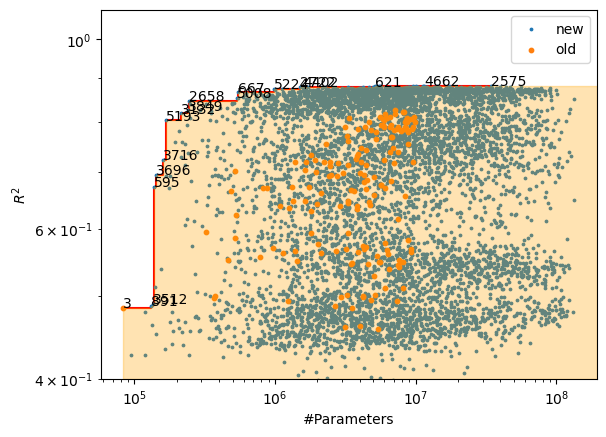

In [18]:
%matplotlib inline
plt.figure()#figsize=(10,10))
# plt.scatter(n_params, max_r2s, c=np.arange(len(n_params)), s=3)
# plt.scatter(n_params, max_r2s, c=labels, s=3)
plt.scatter(n_params[labels==1], max_r2s[labels==1], s=3, label='new')
plt.scatter(n_params[labels==0], max_r2s[labels==0], s=10, label='old')
# plt.scatter(n_params, max_r2s, c=labels, s=3)

(max_r2s_pareto, n_params_pareto), maxr2_nparam_pareto = get_sorted_pareto_front([-max_r2s, n_params])
max_r2s_pareto = -max_r2s_pareto

# plt.scatter(n_params[maxr2_nparam_pareto], max_r2s[maxr2_nparam_pareto], s=10)
for i in range(len(n_params)):
    if maxr2_nparam_pareto[i]:
        plt.annotate(i, (n_params[i], max_r2s[i]))

# plt.plot(n_params_pareto, max_r2s_pareto, color='orange', zorder=-1)
plt.step(n_params_pareto, max_r2s_pareto, color='red', zorder=-1)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('#Parameters')
plt.ylabel('$R^2$')
plt.ylim(0.4, None)
# plt.xlim(66258.87183679479, 192348502.09880182)
# print(plt.ylim())

# Shade pareto suboptimal area
pareto_area_x = np.repeat(n_params_pareto, 2)[::-1]
pareto_area_y = np.repeat(max_r2s_pareto, 2)[::-1]
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
pareto_area_x = np.concatenate([pareto_area_x, [xlims[1]]])
pareto_area_y = np.concatenate([pareto_area_y, [ylims[1]]])
plt.fill_between(pareto_area_x[1:], ylims[0], pareto_area_y[:-1], alpha=0.3, color='orange')
plt.xlim(xlims)
plt.ylim(ylims)

plt.legend()

# plt.savefig('../../Figures/pareto_r2_params_20241210.jpg', bbox_inches='tight')

plt.show()

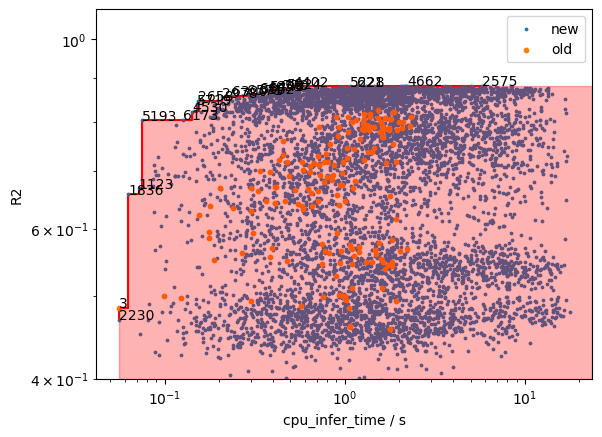

In [19]:
# plt.scatter(cpu_times, max_r2s, c=labels, s=3)#np.arange(len(n_params)))
plt.scatter(cpu_times[labels==1], max_r2s[labels==1], s=3, label='new')
plt.scatter(cpu_times[labels==0], max_r2s[labels==0], s=10, label='old')
# plt.scatter(cpu_times[labels==1], max_r2s[labels==1], s=3)#np.arange(len(n_params)))
# for i in range(len(n_params)):
#     plt.annotate(i, (cpu_times[i], max_r2s[i]))

(max_r2s_pareto, cpu_times_pareto), pareto_flag = get_sorted_pareto_front([-max_r2s, cpu_times])
max_r2s_pareto = -max_r2s_pareto

# plt.plot(cpu_times_pareto, max_r2s_pareto, color='orange', zorder=-1)
test = plt.step(cpu_times_pareto, max_r2s_pareto, color='red', zorder=-1)
# plt.plot(n_params_pareto, max_r2s_pareto, color='orange', zorder=-1)

for i in range(len(n_params)):
    if pareto_flag[i]:
        plt.annotate(i, (cpu_times[i], max_r2s[i]))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('cpu_infer_time / s')
plt.ylabel('R2')
plt.ylim(0.4, None)

# Shade pareto suboptimal area
pareto_area_x = np.repeat(cpu_times_pareto, 2)[::-1]
pareto_area_y = np.repeat(max_r2s_pareto, 2)[::-1]
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
pareto_area_x = np.concatenate([pareto_area_x, [xlims[1]]])
pareto_area_y = np.concatenate([pareto_area_y, [ylims[1]]])
plt.fill_between(pareto_area_x[1:], ylims[0], pareto_area_y[:-1], alpha=0.3, color='red')
plt.xlim(xlims)
plt.ylim(ylims)

plt.legend()

# plt.savefig('../../Figures/pareto_r2_cputime_20241212.jpg', bbox_inches='tight')

plt.show()

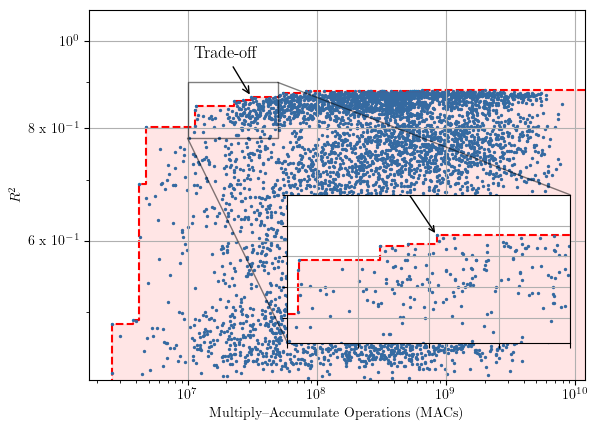

In [30]:
%matplotlib inline
import matplotlib.ticker as ticker
from setup_mpl_tex import setup_mpl_tex

setup_mpl_tex()

ylogscale = True

flops_macs_labels = ["flops_torch","flops_fvcounter","macs_thop","params_thop","macs_ptflops","params_ptflops"]
fmidx = 4

plt.figure()#figsize=(10,10))
plt.scatter(flops_macs[:,fmidx], max_r2s, s=2)#, marker='x')#np.arange(len(n_params)))
# plt.scatter(flops_macs[labels==1,fmidx], max_r2s[labels==1], s=3, label='new')
# plt.scatter(flops_macs[labels==0,fmidx], max_r2s[labels==0], s=10, label='old')

(max_r2s_pareto, fm_pareto), pareto_flag = get_sorted_pareto_front([-max_r2s, flops_macs[:,fmidx]])
max_r2s_pareto = -max_r2s_pareto

# --- Older method --- #
# # plt.plot(fm_pareto, max_r2s_pareto, color='orange', zorder=-1)
# test = plt.step(fm_pareto, max_r2s_pareto, color='red', zorder=-1)

# for i in range(len(n_params)):
#     if pareto_flag[i]:
#         plt.annotate(i, (flops_macs[i,fmidx], max_r2s[i]))
x_annotate,y_annotate = flops_macs[667,fmidx], max_r2s[667]
# plt.annotate(667, (x_annotate, y_annotate))
plt.annotate(
    "Trade-off",
    xy=(x_annotate, y_annotate),            # Point to annotate
    xytext=(x_annotate-2e7, y_annotate+0.09), # Location of the text
    arrowprops=dict(facecolor='black', arrowstyle='->'), # Arrow style
    fontsize=12
)

plt.xscale('log')
if ylogscale:
    plt.yscale('log')
plt.xlabel('Multiply–Accumulate Operations (MACs)')#flops_macs_labels[fmidx])
plt.ylabel('$R^2$')
if ylogscale:
    plt.ylim(0.42, None)
else:
    plt.ylim(0.42, 1.02)

# # Zoom in
# plt.xlim(1e7, 10e8)
# plt.xlim(8e7, 9e7)
# plt.xlim(6e8, 8e8)
# plt.xlim(1e7, 10e8)
# plt.ylim(0.8, 1)

# --- Older method --- #
# # Shade pareto suboptimal area
# pareto_area_x = np.repeat(fm_pareto, 2)[::-1]
# pareto_area_y = np.repeat(max_r2s_pareto, 2)[::-1]
# xlims = plt.gca().get_xlim()
# ylims = plt.gca().get_ylim()
# pareto_area_x = np.concatenate([pareto_area_x, [xlims[1]]])
# pareto_area_y = np.concatenate([pareto_area_y, [ylims[1]]])
# plt.fill_between(pareto_area_x[1:], ylims[0], pareto_area_y[:-1], alpha=0.3, color='red')
# plt.xlim(xlims)
# plt.ylim(ylims)
# --- new method --- #
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
m1_pareto_plot = np.concatenate([[xlim[-1]],fm_pareto,[fm_pareto[-1]]])
m2_pareto_plot = np.concatenate([[max_r2s_pareto[0]],max_r2s_pareto,[ylim[0]]])
test = plt.step(m1_pareto_plot, m2_pareto_plot, color='red', zorder=-1, where='pre', ls='--')

pareto_vertices = test[0].get_path().vertices
plt.fill_between(pareto_vertices[:,0], ylims[0], pareto_vertices[:,1], alpha=0.1, color='red')

plt.xlim(xlim)
plt.ylim(ylim)
# plt.gca().set_yticks([0.5,0.6,0.7,0.8,0.9,1], labels=[0.5,0.6,0.7,0.8,0.9,1])
# plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=2))
if ylogscale:
    custom_ticks = [0.6,0.8,1]
    plt.yticks(custom_ticks, labels=[f'{int(t*10)} x $10^{{-1}}$' if t < 1 else '$10^0$' for t in custom_ticks])
# plt.gca().set_yticks(custom_ticks)
# plt.gca().get_yaxis().set_major_formatter(ticker.LogFormatterSciNotation())
# plt.gca().get_yaxis().set_major_formatter(plt.LogFormatter())
# plt.gca().ticklabel_format(style='sci', axis='y')
# plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0)*0.1, numticks=2))
# plt.gca().yaxis.set_major_formatter(ticker.LogFormatterSciNotation(labelOnlyBase=False))

# inset Axes....
ax = plt.gca()
# x1, x2, y1, y2 = 9e6, 1e8, 0.78, 0.9  # subregion of the original image
x1, x2, y1, y2 = 1e7, 5e7, 0.78, 0.9  # subregion of the original image
# yx_ratio=(y2-y1)/(np.log10(x2)-np.log10(x1))
axins = ax.inset_axes(
    [0.4, 0.1, 0.57, 0.4],
    # [0.5, 0.1, 0.47, 0.3],
    # [0.1, 0.1, 0.87, 0.6],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# axins.imshow(Z2, extent=extent, origin="lower")
axins.scatter(flops_macs[:,fmidx], max_r2s, s=2)#, marker='x')#np.arange(len(n_params)))
test = axins.step(m1_pareto_plot, m2_pareto_plot, color='red', zorder=-1, where='pre', ls='--')
axins.fill_between(pareto_vertices[:,0], ylims[0], pareto_vertices[:,1], alpha=0.1, color='red')
# axins.scatter([x_annotate],[y_annotate], s=2)
axins.annotate(
    "",#Trade-off",
    xy=(x_annotate, y_annotate),            # Point to annotate
    # xytext=(x_annotate-8e6, y_annotate+0.034), # Location of the text
    xytext=(x_annotate-4e6, y_annotate+0.034), # Location of the text
    arrowprops=dict(facecolor='black', arrowstyle='->'), # Arrow style
)
ax.indicate_inset_zoom(axins, edgecolor="black")

ax.grid()
axins.grid()

# plt.yticks(np.arange(ylims[0], ylims[1], 0.01), minor=True)

# plt.gca().yaxis.set_major_formatter(plticker.FormatStrFormatter('%0.01f'))
# plt.legend()
# plt.grid()

# plt.savefig('../../Figures/pareto_r2_cputime_20241212.jpg', bbox_inches='tight')
# plt.savefig('../../Figures/offline_pareto_r2_macs_ylin.pdf', bbox_inches='tight')

plt.show()